<table>
<tr>                                                                                   
     <th>
         <div style='padding:15px;color:#030aa7;font-size:240%;text-align: center;font-style: italic;font-weight: bold;font-family: Georgia, serif'>Autoencodeurs </div>
     </th>
 </tr>
</table>

# <b><div style='padding:18px;background-color:#d8dcd6;color:#030aa7;font-size:130%; border-radius:12px 12px; box-shadow: 8px 8px 8px #042b4c;text-align: left'>Initialisation du document</div></b>

In [2]:
import os
# import json
# @param ["tensorflow", "jax", "torch"]
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ['KERAS_BACKEND'] = 'tensorflow'  
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
# os.environ['TF_XLA_FLAGS']='--tf_xla_auto_jit=1,--tf_xla_always_defer_compilation=true'
# os.environ['XLA_FLAGS']='--xla_backend_optimization_level=0,--xla_gpu_autotune_level=4,--xla_gpu_disable_ptxas_optimizations=true,--xla_gpu_use_cudnn_batchnorm_level=2'
# os.environ['TF_GPU_ALLOCATOR']='cuda_malloc_async'
os.environ['TF_CPP_MIN_LOG_LEVEL']='5'

## <b><div style='padding:15px;background-color:#d8dcd6;color:#030aa7;font-size:100%; border-radius:10px 10px; box-shadow: 8px 8px 8px #042b4c;text-align: left'>Import libriries </div></b>

In [3]:
import numpy as np, pandas as pd, seaborn as sns, warnings, os, sys, pickle, time
from matplotlib import pyplot as plt
from datetime import datetime as dt

import matplotlib.font_manager as fm
from matplotlib.lines import Line2D

warnings.filterwarnings(action="ignore")

if int(str(sns.__version__).split('.')[1]) > 8 : 
    plt.style.use('seaborn-v0_8-darkgrid')
else:
    plt.style.use('seaborn-darkgrid')
    
sns.set(font_scale=2)

In [4]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist,fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.constraints import max_norm

from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator


from sklearn.preprocessing import label_binarize
from sklearn.metrics import make_scorer, confusion_matrix, roc_curve, auc, accuracy_score, log_loss, hamming_loss, \
                            precision_score, recall_score, f1_score, fbeta_score, jaccard_score, \
                            precision_recall_curve, average_precision_score, balanced_accuracy_score, \
                            classification_report,roc_auc_score

tf.get_logger().setLevel('ERROR')# Suppress TensorFlow logging (2)

In [5]:
print("Tensorflow\t : %s\tCUDA %s\tGPU %s\tXLA %s\nKeras\t\t : %s\nPandas\t\t : %s\nNumPy\t\t : %s"%
      (tf.__version__, 
       tf.test.is_built_with_cuda(), 
       tf.test.is_built_with_gpu_support(), 
       tf.test.is_built_with_xla(), 
       tf.keras.__version__, 
       pd.__version__, 
       np.__version__))

Tensorflow	 : 2.17.0	CUDA True	GPU True	XLA True
Keras		 : 3.6.0
Pandas		 : 2.2.2
NumPy		 : 1.26.4


# <b><div style='padding:18px;background-color:#d8dcd6;color:#030aa7;font-size:130%; border-radius:12px 12px; box-shadow: 8px 8px 8px #042b4c;text-align: left'>Initialisation des GPUs presents</div></b>

In [6]:
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
physical_devices = tf.config.experimental.list_physical_devices('GPU')

if len(physical_devices) >  0 :
    for i, gpu in enumerate(physical_devices):
        tf.config.experimental.set_memory_growth(physical_devices[i], True)

    strategy = tf.distribute.experimental.CentralStorageStrategy()
    print('Le système est initialisé avec {0:d} GPUs'.format(strategy.num_replicas_in_sync))

Le système est initialisé avec 1 GPUs


I0000 00:00:1752001576.591512 3022024 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1752001576.611737 3022024 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1752001576.611864 3022024 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1752001576.618116 3022024 service.cc:146] XLA service 0x233a1f70 initialized for platfor

# <b><div style='padding:18px;background-color:#d8dcd6;color:#030aa7;font-size:130%; border-radius:12px 12px; box-shadow: 8px 8px 8px #042b4c;text-align: left'>Outils du document</div></b>

In [7]:
palette = [
            "#030aa7", "#e50000", "#d8863b", "#005f6a", "#6b7c85", "#751973", "#d1e5f0", "#fddbc7",
            "#ffffcb", "#12e193", "#d8dcd6", "#ffdaf0", "#dfc5fe", "#f5054f", "#a0450e",
            "#0339f8", "#f4320c", "#fec615", "#017a79", "#85a3b2", "#fe2f4a", "#a00498", "#b04e0f",
            "#0165fc", "#ff724c", "#fddc5c", "#11875d", "#89a0b0", "#fe828c", "#cb00f5", "#b75203",
            "#0485d1", "#ff7855", "#fbeeac", "#0cb577", "#95a3a6", "#ffb7ce", "#c071fe", "#ca6b02",
            "#92c5de", "#f4a582", "#fef69e", "#18d17b", "#c5c9c7", "#ffcfdc", "#caa0ff", "#cb7723",
            "#d1e5f0", "#fddbc7", "#ffffcb", "#12e193", "#d8dcd6", "#ffdaf0", "#dfc5fe", "#d8863b",
            "#030764", "#be0119", "#dbb40c", "#005249", "#3c4142", "#cb0162", "#5d1451", "#653700",
            "#040348", "#67001f", "#b27a01", "#002d04", "#000000", "#a0025c", "#490648", "#3c0008"
          ]

In [8]:
nom_projet                = "10-L'apprentissage et rappels d’exécution--modèle VGG19--Chaussures-TFRecods"
repertoireProjet          = os.getcwd()
repertoireEnregistrement  = repertoireProjet +'/'+nom_projet+ '/repertoire.images'
repertoireSauvegardes     = repertoireProjet +'/'+nom_projet+ '/repertoire.sauvegardes'

def controleExistenceRepertoire(directory, create_if_needed=True):
    """Voir si le répertoire existe. S'il n'existe pas il est créé."""
    path_exists = os.path.exists(directory)
    if path_exists:
        if not os.path.isdir(directory):
            raise Exception("Trouvé le nom "+directory+" mais c'est un fichier, pas un répertoire")
            return False
        return True
    if create_if_needed:
        os.makedirs(directory)
        
controleExistenceRepertoire(repertoireEnregistrement)
controleExistenceRepertoire(repertoireSauvegardes)

def sauvegarderImage( fichier):
    """Enregistrez la figure. Appelez la méthode juste avant plt.show ()."""
    plt.savefig(os.path.join(repertoireEnregistrement,
                             fichier+f"--{dt.now().strftime('%Y_%m_%d_%H.%M.%S')}.png"), 
                             dpi=600, 
                             bbox_inches='tight')
    
def sauvegarderModelPoids(model, fichierPoids, repertoireSauvegardes=repertoireSauvegardes):
    """Enregistrez les poids du modèle Keras."""
    if fichierPoids != None:
        controleExistenceRepertoire(repertoireSauvegardes)
        nomFichier = os.path.join(repertoireSauvegardes, '{}.keras'.format(fichierPoids))
        model.save_weights(nomFichier)

def sauvegarderModel(model, fichier, repertoireSauvegardes=repertoireSauvegardes):
    """Enregistrez le modèle Keras."""
    if fichier != None:
        controleExistenceRepertoire(repertoireSauvegardes)
        nomFichier = os.path.join(repertoireSauvegardes, '{}.keras'.format(fichier))
        model.save(nomFichier)

def lectureModelPoids(model, fichier, repertoireSauvegardes=repertoireSauvegardes):
    """Si le fichier existe, il est chargé et retourne True, sinon retourne False."""
    nomFichier = os.path.join(repertoireSauvegardes, '{}.keras'.format(fichier))
    if os.path.exists(nomFichier):
        if os.path.isfile(nomFichier):
            model.load_weights(nomFichier)
            return True
    return False

# <b><div style='padding:18px;background-color:#d8dcd6;color:#030aa7;font-size:130%; border-radius:12px 12px; box-shadow: 8px 8px 8px #042b4c;text-align: left'>Lecture des données</div></b>

In [9]:
random_seed = 42
np.random.seed(random_seed)

# load MNIST data and save sizes
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
image_height = X_train.shape[1]
image_width = X_train.shape[2]
number_of_pixels = image_height * image_width

# convert to floating-point
# X_train = tf.cast(X_train, tf.float32)
# X_test  = tf.cast(X_test, tf.float32)

X_train = X_train.astype('float32')
X_test  = X_test.astype('float32')

# scale data to range [0, 1]
X_train /= 255.0
X_test /= 255.0

# save the original y_train and y_test
original_y_train = y_train
original_y_test = y_test

# replace label data with one-hot encoded versions
number_of_classes = 1 + max(np.append(y_train, y_test))
y_train = tf.keras.utils.to_categorical(y_train, num_classes=number_of_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=number_of_classes)

In [11]:
# extra code – loads, scales, and splits the fashion MNIST dataset
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [13]:
X_train_full.shape, X_train.shape,X_valid.shape

((60000, 28, 28), (55000, 28, 28), (5000, 28, 28))

# <b><div style='padding:18px;background-color:#d8dcd6;color:#030aa7;font-size:130%; border-radius:12px 12px; box-shadow: 8px 8px 8px #042b4c;text-align: left'>Implémenter un autoencodeur - PerceptronMulticouche</div></b>

<img src="https://raw.githubusercontent.com/rbizoi/DeepLearning/refs/heads/main/images/autoencodeur_pml.png" width="1024">


In [15]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

stacked_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(1024, activation="selu"),
    tf.keras.layers.Dense(1024, activation="selu"),
    tf.keras.layers.Dense(1024, activation="selu"),
    tf.keras.layers.Dense(30, activation="selu"),
])
stacked_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(1024, activation="selu", input_shape=[30]),
    tf.keras.layers.Dense(1024, activation="selu"),
    tf.keras.layers.Dense(1024, activation="selu"),
    tf.keras.layers.Dense(28 * 28, activation="sigmoid"),
    tf.keras.layers.Reshape([28, 28])
])
stacked_ae = tf.keras.Sequential([stacked_encoder, stacked_decoder])

stacked_ae.compile(loss="mse", optimizer=tf.keras.optimizers.Nadam())                                     
history = stacked_ae.fit(X_train, X_train, epochs=56,
                         validation_data=(X_valid, X_valid))

Epoch 1/56
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0312 - val_loss: 0.0174
Epoch 2/56
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0167 - val_loss: 0.0161
Epoch 3/56
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0156 - val_loss: 0.0156
Epoch 4/56
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0149 - val_loss: 0.0154
Epoch 5/56
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0144 - val_loss: 0.0160
Epoch 6/56
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0141 - val_loss: 0.0145
Epoch 7/56
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0138 - val_loss: 0.0149
Epoch 8/56
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0137 - val_loss: 0.0145
Epoch 9/56
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0135 - val_loss: 0.0145
Epoch 10/56
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0134 - val_loss: 0.0149
Epoch 11/56
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0133 - val_loss: 0.0141
Epoch 12/56
1719/1719 ━━━━━━━━

In [44]:
def plot_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = np.clip(model.predict(images[:n_images]), 0, 1)
    fig = plt.figure(figsize=(n_images * 1.5, 4))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plt.imshow(images[image_index], cmap="binary")
        plt.axis("off")
        if image_index == 0 : plt.title("Images originales")
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plt.imshow(reconstructions[image_index], cmap="binary")
        plt.axis("off")
        if image_index == 0 : plt.title("Reconstruction")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


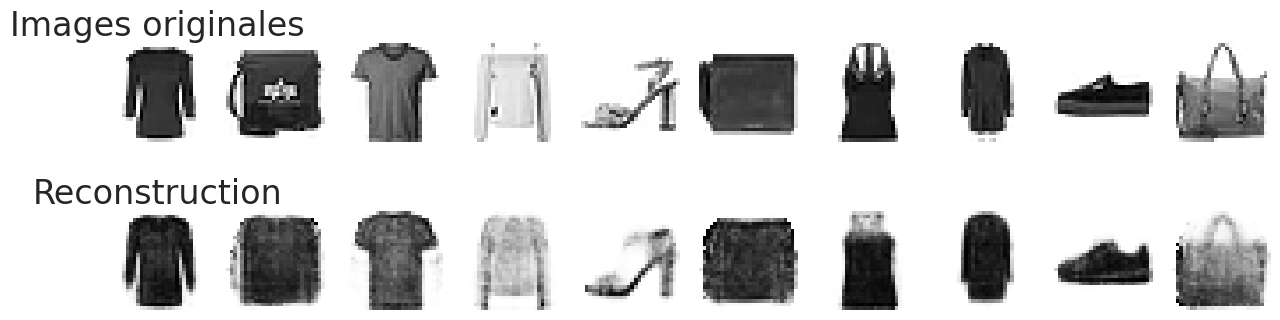

In [45]:
plot_reconstructions(stacked_ae, n_images=10)

# <b><div style='padding:18px;background-color:#d8dcd6;color:#030aa7;font-size:130%; border-radius:12px 12px; box-shadow: 8px 8px 8px #042b4c;text-align: left'>Entraîner un autoencodeur à la fois</div></b>

<img src="https://raw.githubusercontent.com/rbizoi/DeepLearning/refs/heads/main/images/autoencodeur01.png" width="1024">


In [47]:
def train_autoencoder(n_neurons, X_train, X_valid, n_epochs=10,
                      output_activation=None, learning_rate=1e-3):
    n_inputs = X_train.shape[-1]
    encoder = tf.keras.layers.Dense(n_neurons, activation="relu")
    decoder = tf.keras.layers.Dense(n_inputs, activation=output_activation)
    autoencoder = tf.keras.Sequential([encoder, decoder])
    optimizer = tf.keras.optimizers.Nadam(learning_rate=learning_rate)
    autoencoder.compile(loss="mse", optimizer=optimizer)
    autoencoder.fit(X_train, X_train, epochs=n_epochs,
                    validation_data=(X_valid, X_valid))
    return encoder, decoder, encoder(X_train), encoder(X_valid)

In [48]:
tf.random.set_seed(42)

X_train_flat = tf.keras.layers.Flatten()(X_train)
X_valid_flat = tf.keras.layers.Flatten()(X_valid)
enc1, dec1, X_train_enc1, X_valid_enc1 = train_autoencoder(
    100, X_train_flat, X_valid_flat, n_epochs=56, learning_rate=5e-4)
enc2, dec2, _, _ = train_autoencoder(
    30, X_train_enc1, X_valid_enc1, output_activation="relu", n_epochs=56, learning_rate=5e-3)

Epoch 1/56
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0382 - val_loss: 0.0130
Epoch 2/56
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 849us/step - loss: 0.0120 - val_loss: 0.0104
Epoch 3/56
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0100 - val_loss: 0.0095
Epoch 4/56
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0093 - val_loss: 0.0091
Epoch 5/56
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 789us/step - loss: 0.0090 - val_loss: 0.0089
Epoch 6/56
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 623us/step - loss: 0.0088 - val_loss: 0.0087
Epoch 7/56
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 871us/step - loss: 0.0086 - val_loss: 0.0085
Epoch 8/56
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0085 - val_loss: 0.0085
Epoch 9/56
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 976us/step - loss: 0.0084 - val_loss: 0.0084
Epoch 10/56
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 923us/step - loss: 0.0083 - val_loss: 0.0083
Epoch 11/56
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0082 - val_loss: 0.0082
Epoch 12/56
1719/1

In [49]:
stacked_ae_1_by_1 = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    enc1, enc2, dec2, dec1,
    tf.keras.layers.Reshape([28, 28])
])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


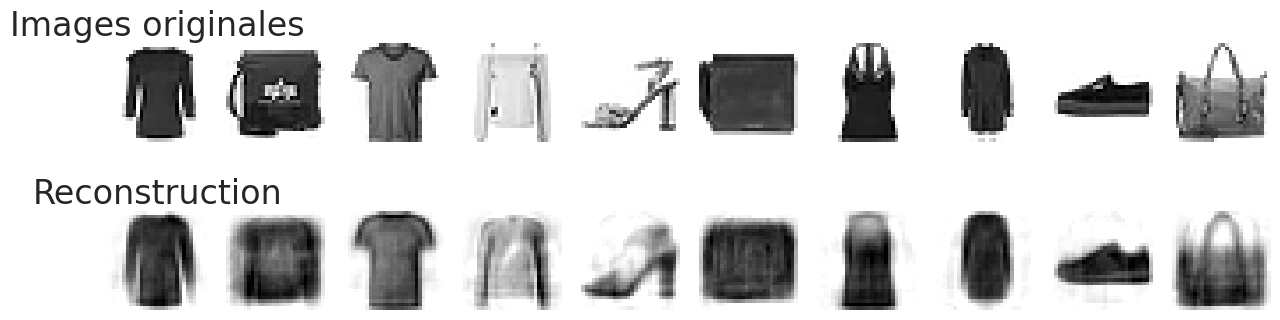

In [61]:
plot_reconstructions(stacked_ae_1_by_1, n_images=10)
plt.show()

In [51]:
stacked_ae_1_by_1.compile(loss="mse", optimizer=tf.keras.optimizers.Nadam())
history = stacked_ae_1_by_1.fit(X_train, X_train, epochs=5,
                                validation_data=(X_valid, X_valid))

Epoch 1/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0192 - val_loss: 0.0177
Epoch 2/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0172 - val_loss: 0.0160
Epoch 3/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 793us/step - loss: 0.0155 - val_loss: 0.0151
Epoch 4/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0148 - val_loss: 0.0147
Epoch 5/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 663us/step - loss: 0.0143 - val_loss: 0.0143


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


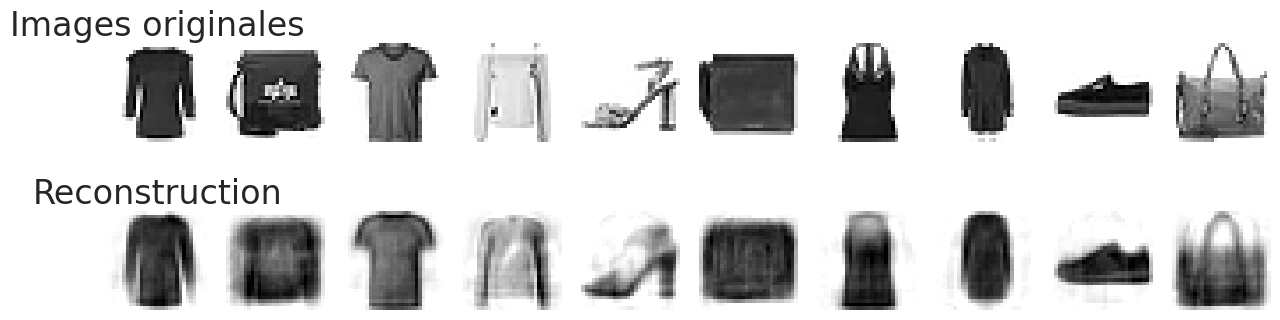

In [62]:
plot_reconstructions(stacked_ae_1_by_1, n_images=10)
plt.show()

# <b><div style='padding:18px;background-color:#d8dcd6;color:#030aa7;font-size:130%; border-radius:12px 12px; box-shadow: 8px 8px 8px #042b4c;text-align: left'>Autoencodeurs convolutifs</div></b>

In [59]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

conv_encoder = tf.keras.Sequential([
    tf.keras.layers.Reshape([28, 28, 1]),
    tf.keras.layers.Conv2D(16, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2),  # output: 14 × 14 x 16
    tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2),  # output: 7 × 7 x 32
    tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2),  # output: 3 × 3 x 64
    tf.keras.layers.Conv2D(30, 3, padding="same", activation="relu"),
    tf.keras.layers.GlobalAvgPool2D()  # output: 30
])
conv_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(3 * 3 * 16),
    tf.keras.layers.Reshape((3, 3, 16)),
    tf.keras.layers.Conv2DTranspose(32, 3, strides=2, activation="relu"),
    tf.keras.layers.Conv2DTranspose(16, 3, strides=2, padding="same",
                                    activation="relu"),
    tf.keras.layers.Conv2DTranspose(1, 3, strides=2, padding="same"),
    tf.keras.layers.Reshape([28, 28])
])
conv_ae = tf.keras.Sequential([conv_encoder, conv_decoder])

# extra code – compiles and fits the model
conv_ae.compile(loss="mse", optimizer=tf.keras.optimizers.Nadam())
history = conv_ae.fit(X_train, X_train, epochs=56,
                      validation_data=(X_valid, X_valid))

Epoch 1/56
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.0451 - val_loss: 0.0213
Epoch 2/56
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0203 - val_loss: 0.0186
Epoch 3/56
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0179 - val_loss: 0.0171
Epoch 4/56
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0164 - val_loss: 0.0160
Epoch 5/56
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0155 - val_loss: 0.0152
Epoch 6/56
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0147 - val_loss: 0.0146
Epoch 7/56
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0141 - val_loss: 0.0142
Epoch 8/56
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0137 - val_loss: 0.0139
Epoch 9/56
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0133 - val_loss: 0.0139
Epoch 10/56
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0130 - val_loss: 0.0131
Epoch 11/56
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0127 - val_loss: 0.0132
Epoch 12/56
1719/1719 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step


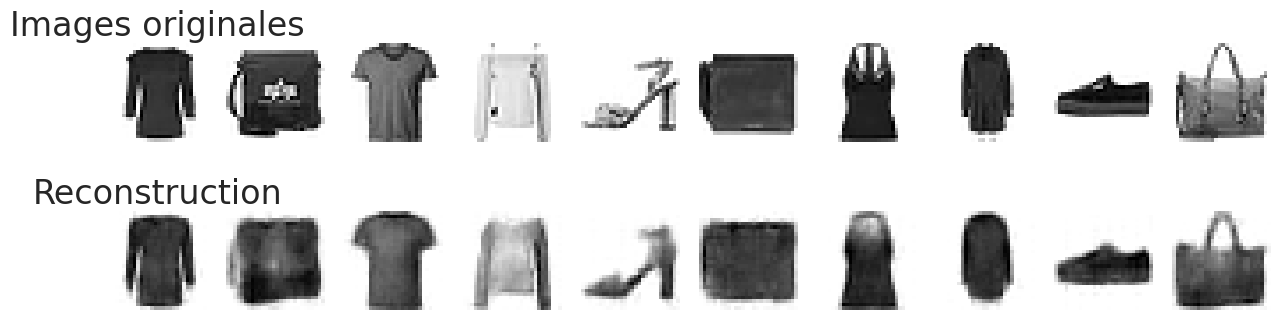

In [63]:
# extra code – shows the reconstructions
plot_reconstructions(conv_ae, n_images=10)
plt.show()

# <b><div style='padding:18px;background-color:#d8dcd6;color:#030aa7;font-size:130%; border-radius:12px 12px; box-shadow: 8px 8px 8px #042b4c;text-align: left'>Autoencodeurs débruiteurs</div></b>

<img src="https://raw.githubusercontent.com/rbizoi/DeepLearning/refs/heads/main/images/autoencodeur02.png" width="1024">


In [64]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

dropout_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2048, activation="relu"),
    tf.keras.layers.Dense(1024, activation="relu"),
    tf.keras.layers.Dense(512, activation="relu"),
    tf.keras.layers.Dense(30, activation="relu")
])
dropout_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation="relu", input_shape=[30]),
    tf.keras.layers.Dense(1024, activation="relu"),
    tf.keras.layers.Dense(2048, activation="relu"),
    tf.keras.layers.Dense(28 * 28),
    tf.keras.layers.Reshape([28, 28])
])
dropout_ae = tf.keras.Sequential([dropout_encoder, dropout_decoder])

# extra code – compiles and fits the model
dropout_ae.compile(loss="mse", optimizer=tf.keras.optimizers.Nadam())
history = dropout_ae.fit(X_train, X_train, epochs=56,
                         validation_data=(X_valid, X_valid))

Epoch 1/56
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 0.0463 - val_loss: 0.0226
Epoch 2/56
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0201 - val_loss: 0.0186
Epoch 3/56
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0183 - val_loss: 0.0168
Epoch 4/56
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0173 - val_loss: 0.0156
Epoch 5/56
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0167 - val_loss: 0.0152
Epoch 6/56
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0162 - val_loss: 0.0148
Epoch 7/56
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0159 - val_loss: 0.0149
Epoch 8/56
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0156 - val_loss: 0.0144
Epoch 9/56
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0153 - val_loss: 0.0142
Epoch 10/56
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0151 - val_loss: 0.0141
Epoch 11/56
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0150 - val_loss: 0.0140
Epoch 12/56
1719/1719 ━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


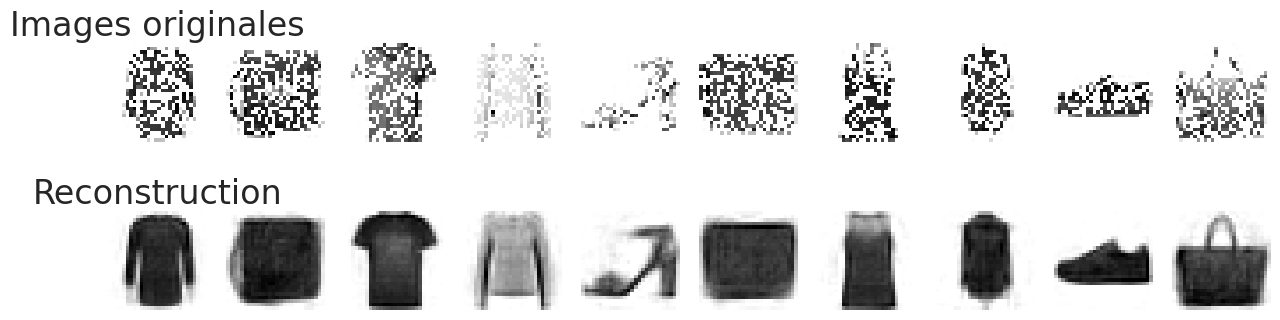

In [65]:
tf.random.set_seed(42)
dropout = tf.keras.layers.Dropout(0.5)
plot_reconstructions(dropout_ae, dropout(X_valid, training=True), n_images=10)
plt.show()